# STEM EDS element quantification and signal clustering

Investigating and segmenting phases based on their chemical fingerprints in e.g. scanning transmission electron microscopy (STEM) energy dispersive spectroscopy (EDS) can provide valuable information. Based on the investigations in [Sørhaug et al., Materials & Design, 2024](https://doi.org/10.1016/j.matdes.2024.112867) on aluminium-copper (Al, Cu) joints, this notebook will reproduce the main results where intermetallic phase layers are identified and segmented using k-means++. Additionally, the alloy elements magnesium (Mg) and silicon (Si) from Al are identified incorporated in one of the layers. (Figure 1.)

# Author 
* 2024.05.30 Jørgen A. Sørhaug - Developed EDS analysis of intermetallic phase layers in Al-Cu weld. 

# Requirements
* or exspy version 0.2 and scikit-learn version 1.5.0

# Contents
1. [Specimen and data](#one)
2. [Loading and viewing](#two)
3. [Navigation binning and signal cropping](#three)
4. [Model fitting and element quantification](#four)
5. [Clustering intermetallic phase layers](#five)

# <a id='one'></a> 1. Specimen and data

The Al-Cu specimen and data are described in [Sørhaug, J. A. et al., Materials & Design, 2024](https://doi.org/10.1016/j.matdes.2024.112867). The specimen has been made by focused ion beam (FIB) lift-out, taken from the bimetallic weld interface. A platinum (Pt) precursor gas was deposited as protection prior to specimen lift-out and relocation to a Mo FIB-TEM grid. The ion source is gallium (Ga). Ga degenerate aluminium by infiltrating grain boundaries. High concentrations of Ga should therefore surround Al grain boundaries. 

Al-Cu intermetallic phases (IMP) are investigated using STEM-EDS (JEOL JEM-ARM200CF integrated with CEOS spherical aberration correctors in probe and image forming optics). Since the Al is a 6xxx alloy with high concentrations of Si and Mg, we will investigate whether alloying elements can be found in the intermetallic layers. 

![alt text](images/ga.png)

Figure 1: (a) Bright-field STEM image of the Al-Cu weld interface, revealing nano-sized intermetallic phases at the interface. (b) High-angle annular dark field STEM image. The objective here is to segment the four layers (Al, Al-rich IMP layer, Cu-rich IMP layer, and Cu) so that we can extract chemical information from layers of interest. (c) Summed EDS spectra from the Al-rich and Cu-rich IMPs. Si and Mg are found embedded in the Al-rich IMP layer.

# <a id='two'></a> 2. Loading and viewing
The data is available from [Zenodo repository](https://doi.org/10.5281/zenodo.10478342). This notebook uses the dataset found in the zipped folder named AW.

Import libraries:

In [1]:
%matplotlib qt
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import pooch

Download data from zenodo repository and unzip the folder

In [ ]:
downloader = pooch.DOIDownloader()
url = 'doi:10.5281/zenodo.10478342/AW.zip'

downloader(url=url, output_file='AW.zip', pooch = None)

Load HAADF STEM image and EDS spectrum. (Acquired synchronously.) The HAADF STEM image is identical to Figure 1 (b).

In [3]:
haadf_fn = 'AW/AW/TEM/EDS/HAADF.dm3'
filename = 'AW/AW/TEM/EDS/EDSmap.dm3'


haadf = hs.load(haadf_fn) 
s = hs.load(filename)

WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:254)
WARNING | Hyperspy | Numba is not installed, fal

Plot HAADF STEM image. The Al alloy is on the top, which is why we see particles dispersed. Pure Cu is at the bottom. Intermetallic phase layers are found in between.

In [ ]:
haadf.plot()

Plot spectrum for signal inspection.

In [ ]:
s.plot()

It can be seen that a single spectrum has very high counts (1391,195). The reason is not known, but is likely caused by a Software lag causing the probe to be stationary for some time while the EDS detector was operating. This will, however, not influence the final results as the pixel is not part of the region of interest (ROI) and can easily be removed:

In [ ]:
s.inav[1391, 195].plot()

Plot sum spectrum and inspect the peaks.

In [ ]:
s_sum = s.sum()
s_sum.plot()

Add elements to the signal: parent materials, alloy elements, contaminants (oxides, hydrocarbons, Ar from plasma cleaning) and elements stemming from the environment (FIB-TEM grid, Pt protection layer, TEM column).

In [4]:
main_Elements = ['Al','Cu']

minor_Elements = ['Si','Mg','Mn','Fe','Cr','Zr','Ti','C','O','Ga','Ar']

environment_Elements = ['Mo','Co'] 

elements = main_Elements + minor_Elements + environment_Elements

Set the elements to the sum signal metadata, add lines, and plot.

In [ ]:
s_sum.set_elements(elements)
s_sum.add_lines()

s_sum.plot(xray_lines = 'from_elements')

Investigate non-identified peaks.

In [ ]:
observed_uncharacterised_peak = 9.4 # keV; 
width = 0.1

# Depending on the hyperspy version:
from exspy.misc.eds.utils import get_xray_lines_near_energy
    
print('E =', str(observed_uncharacterised_peak), "\u00B1", width, 'keV may be ' + 
      str(get_xray_lines_near_energy(energy = (observed_uncharacterised_peak), width = width)))

We see that Pt can explain the small peak at ~9.4 keV. Pt percursor gas was used to make a protection layer during specimen preparation. We don't expect Pt in the region of interest (it is several $\mu m$ away), but Pt X-rays are emitted as scattered electrons or X-rays from elsewhere hit the protection layer. 

In [ ]:
elements.append('Pt')

Re-plot the sum spectrum.

In [ ]:
s_sum.set_elements(elements)
s_sum.plot(xray_lines = 'from_elements')

Set only elements of interest to the signal metadata. Pt will not be included as it is not part of the scanned ROI.

In [13]:
# Ignoring environment elements from the e.g. the microscope etc.
elements = main_Elements + minor_Elements

s.set_elements(elements)
s.add_lines()

# <a id='three'></a> 3. Navigation binning and signal cropping
Because of the low number of counts in each pixel, the navigation axis will be binned to enhance the signal-to-noise ratio. We also crop the siganl to exclude energy ranges of no interest. This can benefit the model fitting that will be performed later.

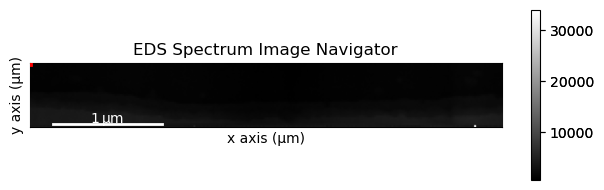

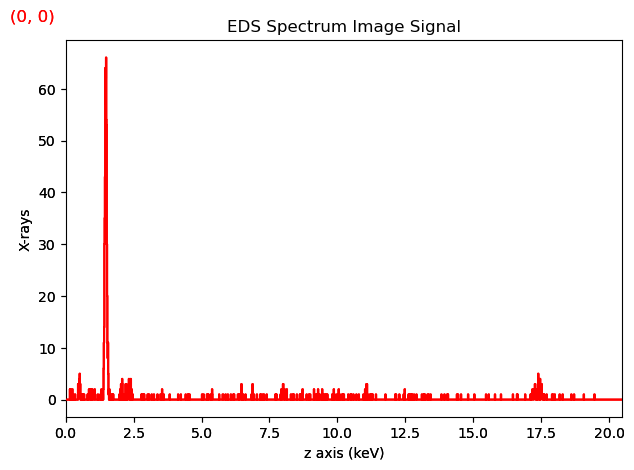

In [5]:
bins = (6,6,1) # (x, y, signal)

s_bin = s.rebin(scale = bins)
s_bin.add_elements(elements)

## 3.1 Crop signal
Check element X-ray ranges:

In [29]:
# Get hyperspy material elements as dictionary
from exspy.misc.elements import elements as mat_dict

maxE = ['',0] # Element, energy
for e in s.metadata.Sample.xray_lines:
    elem, line = e.split('_')
    energy = mat_dict[elem]['Atomic_properties']['Xray_lines'][line]['energy (keV)']
    if maxE[-1] < energy: 
        maxE[-1] = energy
        maxE[0] = elem
    print(elem + ':', energy, 'keV')
print('\nMaximum energy:', maxE, 'keV')

Al: 1.4865 keV
Ar: 2.9577 keV
C: 0.2774 keV
Cr: 5.4147 keV
Cu: 8.0478 keV
Fe: 6.4039 keV
Ga: 9.2517 keV
Mg: 1.2536 keV
Mn: 5.8987 keV
O: 0.5249 keV
Si: 1.7397 keV
Ti: 4.5109 keV
Zr: 15.7753 keV

Maximum energy: ['Zr', 15.7753] keV


Crop signal.

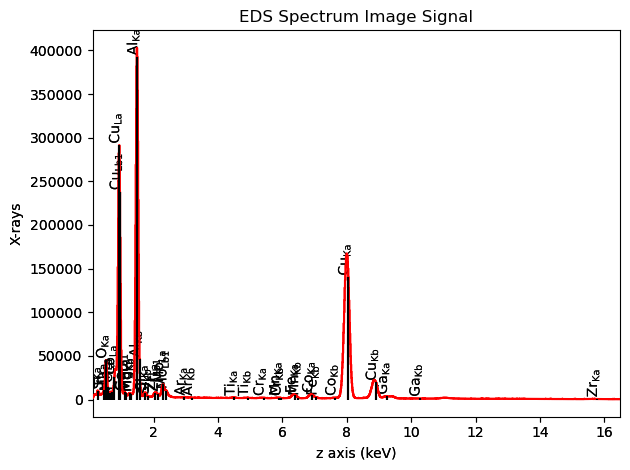

In [6]:
sig_range = (0.1, 16.5) #keV

s_bin_crop = s_bin.isig[sig_range[0]:sig_range[-1]]

# <a id='four'><a> 4. Model fitting and element quantification

We want to fit a model to out signal prior to element quantification. We will also use it for signal clustering.

In [7]:
s = s_bin_crop

## 4.1 Create initial model

In [ ]:
m = s.create_model()

In [ ]:
m.plot()

We can see that the energy calibration is slightly off at high energies. Fit the model, the background and calibrate energy axis:

In [ ]:
m.fit(bounded = True)
m.fit_background()
m.calibrate_energy_axis(calibrate='scale')
m.calibrate_energy_axis(calibrate='offset')

In [ ]:
m.plot()

## 4.2 Perform multifitting

In [ ]:
m.multifit(bounded = True)

Re-fit background.

In [ ]:
m.fit_background()
m.fit(bounded = True)

Save the model.

In [ ]:
m.save('model.hspy')

Make the model into a signal. We will use this for signal clustering.

In [ ]:
m_sig = m.as_signal()

Save model as signal:

In [ ]:
m_sig.save('model_as_signal.hspy')

## 4.3 Element quantification
Define k-factors for Cliff-Lorimer quantification. These are taken from the used microscope, and depend on the microscope setup.

In [ ]:
k_factors = dict()

k_factors['Al_Ka'] = 1.040
k_factors['Ar_Ka'] = 2.957
k_factors['C_Ka'] = 4.283
k_factors['Cr_Ka'] = 1.427 
k_factors['Cu_Ka'] = 2.023 
k_factors['Fe_Ka'] = 1.585 
k_factors['Fe_La'] = 6.021 
k_factors['Ga_Ka'] = 2.419 
k_factors['Ga_La'] = 4.719 
k_factors['Mg_Ka'] = 1.054 
k_factors['Mn_Ka'] = 1.526 
k_factors['O_Ka'] = 1.815 
k_factors['Si_Ka'] = 1.000
k_factors['Ti_Ka'] = 1.321 
k_factors['Zr_Ka'] = 6.94 
k_factors['Zr_La'] = 3.901

Set relevant k-factors in the same order as the signal xray_lines

In [14]:
line_list = np.array(s.metadata.Sample.xray_lines)
kfactors = [k_factors[line] for line in line_list]

Get model intensities:

In [18]:
m_intensities = m.get_lines_intensity(xray_lines=line_list)

Perform element quantification using the Cliff-Lorimer approach:

In [19]:
q = s.quantification(m_intensities, method='CL', factors=kfactors)

[########################################] | 100% Completed | 101.38 ms


### 4.3.1 Plot quantified element maps
Plot quantified element maps:

[<Axes: title={'center': 'Al'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Ar'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'C'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Cr'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Cu'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Fe'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Ga'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Mg'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Mn'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'O'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Si'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Ti'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>,
 <Axes: title={'center': 'Zr'}, xlabel='x axis (µm)', ylabel='y axis (µm)'>]

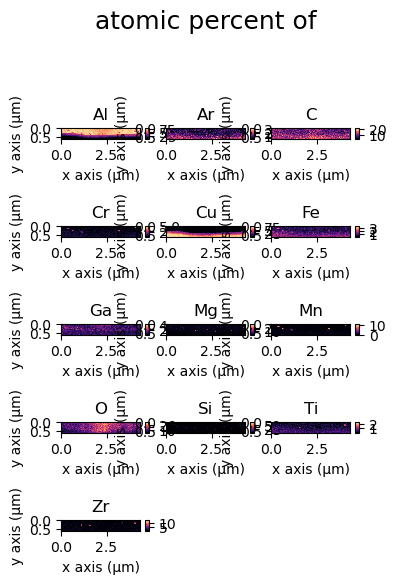

In [20]:
hs.plot.plot_images(q, cmap = 'magma', axes_decor='off', per_row = 5)

Define a list containing the quantified elements. The order corresponds to the order in q

In [ ]:
elem_list = s.metadata.Sample.elements

Plot specific element maps:

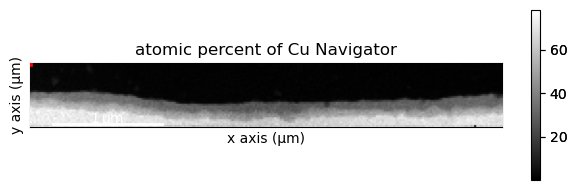

In [22]:
elem = 'Cu'
q[elem_list.index(elem)].plot()

# <a id='five'><a>5 Spectra clustering
It's important to be aware that signals outght to be similar prior to clustering. Otherwise we might get strange results. Spectrum intensities should therefore be normalized. 

We could've used environment elements such as signals from the Mo grid. However, as Al and Cu are the major elements and Al is not capable of exciting Mo, we will use the at.\% ratios between Al and Cu to normalize the model: 

\begin{align}
\text{ratio}_{ij} = \frac{[\text{elem.1}]_{ij}}{([\text{elem.1}]_{ij} + [\text{elem.2}]_{ij})}.
\end{align}

Specifically, we will use the peak value for either $\text{Al}_{K\alpha}$ or $\text{Cu}_{K\alpha}$ as defined by a threshold ratio. I.e. the threshold tells ut when to use the former or the latter.

## 5.1 Spectra normalization
Specify elements of interest (EOI) to cluster and define the element ratio map.

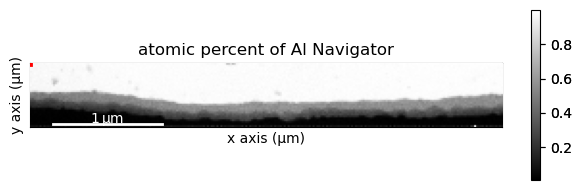

In [27]:
EOI = ['Al', 'Cu']

ratio_map = q[elem_list.index(EOI[0])] / (q[elem_list.index(EOI[0])] + q[elem_list.index(EOI[1])])
ratio_map.plot()

Specify $K\alpha$ line ranges (keV):

In [30]:
width = 0.1

E_vals = {EOI[0] : np.asarray([mat_dict[EOI[0]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - width,
                              mat_dict[EOI[0]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] + width]), 
          EOI[1] : np.asarray([mat_dict[EOI[1]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - width,
                              mat_dict[EOI[1]]['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] + width])} 

Define the ratio map threshold and normalize the model:

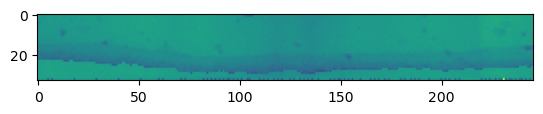

In [31]:
ratio_thresh = 0.1

# Get shapes
(X, Y), E_scale = m.axes_manager.navigation_shape[::-1], m.axes_manager[-1].scale

# Define intensity scale map
SI_scale = np.ndarray((X,Y))

# Find max intensity for EOI1s Ka and store the value
si_temp = m_sig.isig[E_vals[EOI[0]][0]:E_vals[EOI[0]][1]]
scale_roi = np.where(ratio_map.data > ratio_thresh)
SI_scale[scale_roi] = si_temp.max(-1).data[scale_roi]

# Same as above for EOI2
si_temp = m_sig.isig[E_vals[EOI[1]][0]:E_vals[EOI[1]][1]]
scale_roi = np.where(ratio_map.data < ratio_thresh)
SI_scale[scale_roi] = si_temp.max(-1).data[scale_roi]

plt.figure()
plt.imshow(np.log(SI_scale))
plt.show()

Normalize signal model:

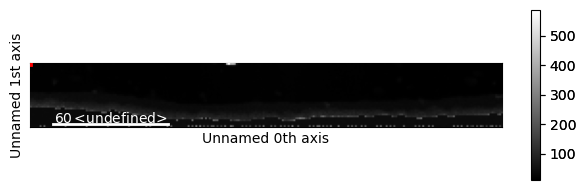

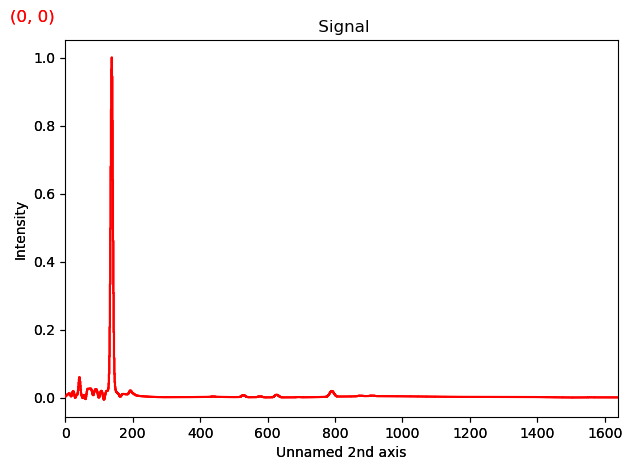

In [32]:
ms_scaled = hs.signals.Signal1D(np.divide(m_sig.deepcopy().data, np.reshape(SI_scale, SI_scale.shape + (1,)))) 
ms_scaled.plot()

Save signal:

In [ ]:
ms_scaled.save('ms_scaled.hspy')

## 5.2 Spectra clustering
Cluster analysis compares and groups signals that lie closest together. Different algorithms exists with different clustering properties (see [scikit-learn](https://scikit-learn.org/stable/modules/clustering.html)). Here, the simple k-means algorithm will be employed. As initialization is important, k-means++ will be used. It initializes centroids to be (generally) distant from one another. 

Estimate number of clusters:

In [34]:
best_k = ms_scaled.estimate_number_of_clusters(cluster_source="signal", metric="silhouette")

  0%|          | 0/9 [00:00<?, ?it/s]

<Axes: xlabel='number of clusters', ylabel='silhouette_metric'>

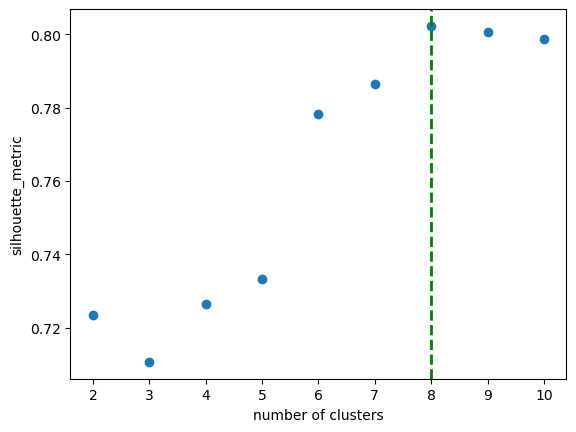

In [35]:
ms_scaled.plot_cluster_metric()

We see that 8 cluster centers are suggested, but we are only interested in four: Al, Al-rich IMP layer, Cu-rich IMP layer and Cu

Perform signal clustering:

In [50]:
n_clusters = 4

c = m_sig.deepcopy()
c_info = c.cluster_analysis(cluster_source = "signal", n_clusters = n_clusters, preprocessing = "norm", 
                                algorithm = 'kmeans', return_info = True)
labels = c.get_cluster_labels()
signals = c.get_cluster_signals()

Plot results; we see we've segmented four layers: Al (top), an Al-rich (second at the top) and a Cu-rich (second at the bottom) intermetallic layer, and Cu (bottom).

WARNING | Hyperspy | Axes labels were requested, but one or both of the axes units and/or name are undefined. Axes decorations have been set to 'ticks' instead. (hyperspy.drawing.utils:1166)


[<Axes: title={'center': ' (0,)'}>,
 <Axes: title={'center': ' (1,)'}>,
 <Axes: title={'center': ' (2,)'}>,
 <Axes: title={'center': ' (3,)'}>]

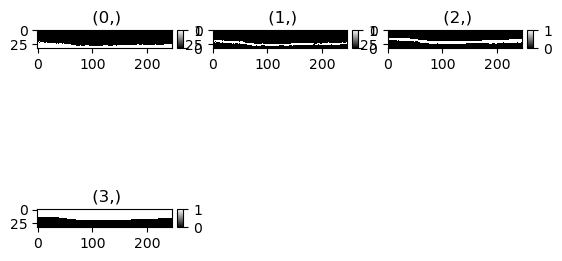

In [51]:
hs.plot.plot_images(labels)

<Axes: xlabel='z (keV)', ylabel='Intensity'>

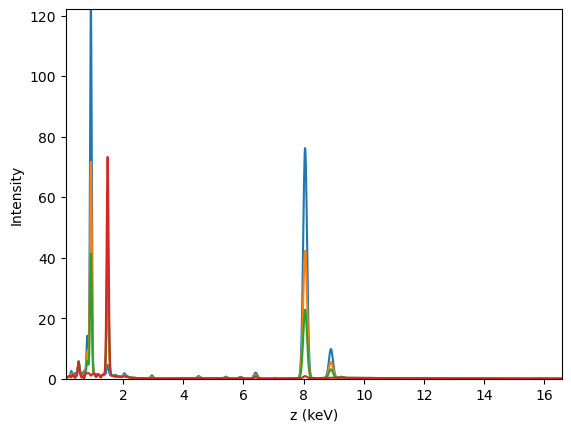

In [52]:
hs.plot.plot_spectra(signals)

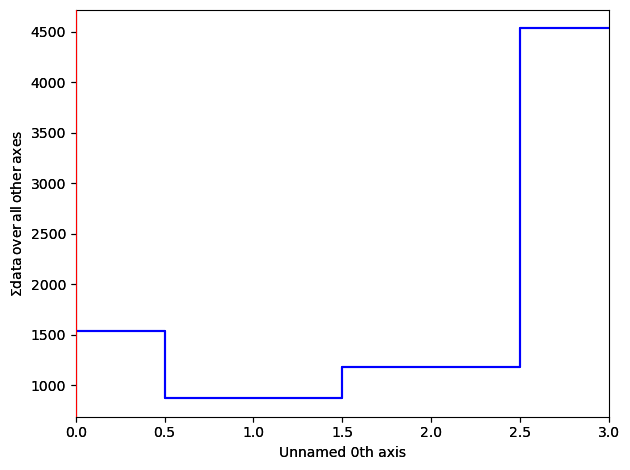

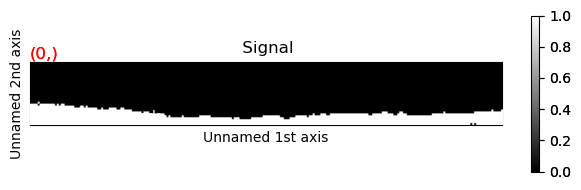

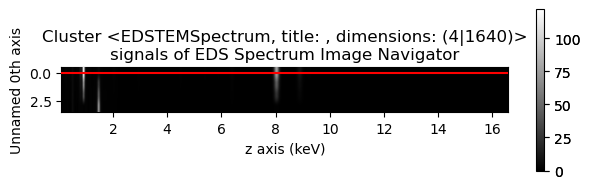

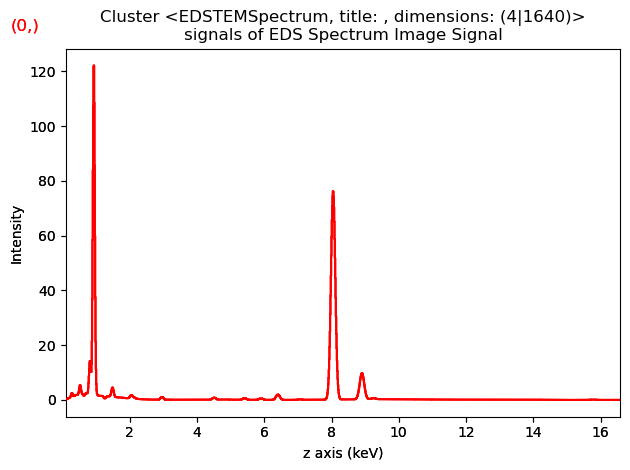

In [53]:
hs.plot.plot_signals([labels, signals])

It should be stressed that it's important to run the clustering several times to ensure consistent results. Due to initialization, some pixels might be labelled differently between each run. If many pixels are labelled differently, a different normalization routine should be used. It might also happen that clustering is not suitable. Here, little difference should take place between each run.

Save results

In [ ]:
c.learning_results.save('learning_results')

## 5.2 Get segmented spectra
Remove outliers

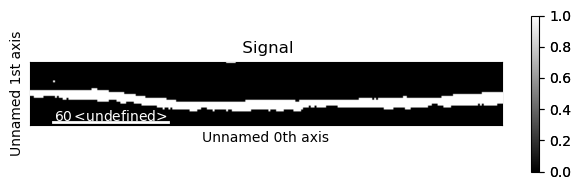

In [61]:
labels.inav[2].plot()

In [62]:
label_ids = [1,2] # Labels of interest
min_size = 6 # Remove small pixels that are not part of the layers

from skimage.morphology import remove_small_objects as rso
IMP_layers = np.asarray([rso(labels.data[i].astype(bool), min_size = min_size) for i in label_ids])

Save masks

In [ ]:
np.save('intermetallic_layers', nav_masks)

## 5.3 Get spectra from defined IMP layers

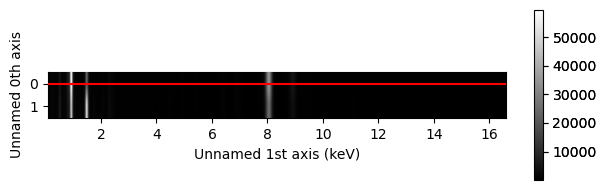

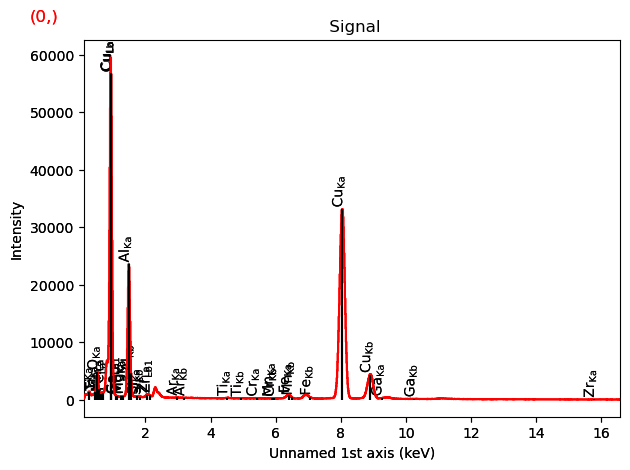

In [ ]:
import exspy
IMP_spectra = exspy.signals.EDSTEMSpectrum([np.sum(s.data[np.where(IMP_layers[i])], axis = 0) for i in range(len(IMP_layers))])

IMP_spectra.axes_manager[-1].scale = m.axes_manager[-1].scale
IMP_spectra.axes_manager[-1].offset = m.axes_manager[-1].offset
IMP_spectra.axes_manager[-1].units = m.axes_manager[-1].units

IMP_spectra.set_elements(elements)
IMP_spectra.add_lines()
IMP_spectra.plot(xray_lines = 'from_elements')

#### Plot with Xray line labels

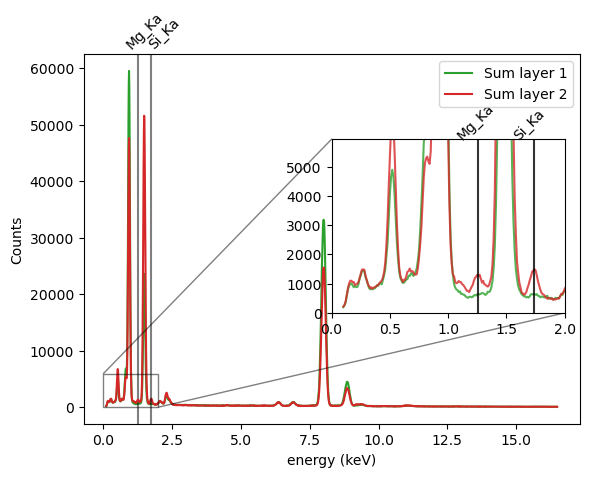

In [146]:
fig, ax = plt.subplots()

sig_shape = s.axes_manager.signal_extent
sig_scale = s.axes_manager[-1].scale
xrange = np.linspace(sig_shape[0], sig_shape[1], s.axes_manager[-1].size)

ax.plot(xrange, IMP_spectra.data[0], c = 'tab:green', label = 'Sum layer 1')

# Annotate Mg_Ka:
ax.axvline(x = mat_dict['Mg']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'], 
              ymin = 0, ymax=1, c = 'k', alpha = 0.5)
ax.text(x = mat_dict['Mg']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - 0.5, 
              y = np.max(IMP_spectra.data + 4e3), s = 'Mg_Ka', rotation = 45)
ax.plot(xrange, IMP_spectra.data[1], c = 'tab:red', label = 'Sum layer 2')

# Annotate Si_Ka:
ax.axvline(x = mat_dict['Si']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'], 
              ymin = 0, ymax=1, c = 'k', alpha = 0.5)
ax.text(x = mat_dict['Si']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - 0.2, 
              y = np.max(IMP_spectra.data + 4e3), s = 'Si_Ka', rotation = 45)
# Set labels
ax.set_xlabel('energy (keV)')
ax.set_ylabel('Counts')
ax.legend()





# Inset ranges:
x1, x2, y1, y2 = 0, 2.0, 0, np.max(IMP_spectra.data) / 10 

# Inset's relative position:
axins = ax.inset_axes(
    [0.5, 0.3, 0.47, 0.47], # [x, y, width, height] w.r.t. ax
    xlim=(x1, x2), ylim=(y1, y2))

# Plot zoomed-in data:
axins.plot(xrange[int(x1/sig_scale):int(x2/sig_scale)], 
           IMP_spectra.data[0, int(x1/sig_scale):int(x2/sig_scale)], c = 'tab:green',
          alpha = 0.8)
axins.plot(xrange[int(x1/sig_scale):int(x2/sig_scale)], 
           IMP_spectra.data[1, int(x1/sig_scale):int(x2/sig_scale)], c = 'tab:red',
          alpha = 0.8)

# Put on horizontal lines:
axins.axvline(x = mat_dict['Mg']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'], 
              ymin = 0, ymax=1, c = 'k', alpha = 0.8)
axins.text(x = mat_dict['Mg']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - 0.2, 
              y = y2, s = 'Mg_Ka', rotation = 45)
axins.axvline(x = mat_dict['Si']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'], 
              ymin = 0, ymax=1, c = 'k', alpha = 0.8)
axins.text(x = mat_dict['Si']['Atomic_properties']['Xray_lines']['Ka']['energy (keV)'] - 0.2, 
              y = y2, s = 'Si_Ka', rotation = 45)

# Indicate inset:
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

Bin HAADF STEM image 

In [ ]:
haadf = haadf.rebin(scale = bins[:-1])

Plot corresponding RGB image of the cluster labels and overlay on HAADF STEM image

In [ ]:
haadf.data /= haadf.data.min()

# Make a list of images for overlay:
arr = []
arr.append(hs.signals.BaseSignal(haadf))
for i in range(len(IMP_layers)): arr.append(hs.signals.BaseSignal(IMP_layers[i].astype(int)))

# Overlay images:
hs.plot.plot_images(arr, scalebar='all', overlay=True, colors = ['grey','tab:green','red'])

From the obtained results, we first see two layers of different Al and Cu concentrations. However, in Layer 1 we also observe intensity from Si and Mg. If we inspect the element maps, we can see that the signals are from particles embedded in Layer 1! 

In [ ]:
imp_layer_index = 1
element = 'Si'

plt.figure()
plt.imshow(IMP_layers[imp_layer_index]*q[elem_list.index(element)], vmax = 10, cmap = 'magma')
plt.show()